# Using `bw2landbalancer`

Notebook showing typical usage of `bw2landbalancer`

## Generating the samples

`bw2landbalancer` works with Brightway2. You only need set as current a project in which the database for which you want to balance land transformation exchanges is imported.

In [1]:
import brightway2 as bw
import numpy as np
bw.projects.set_current('ei36cutoff') # Project with ecoinvent 3.6 cut-off by classification already imported

The only Class you need is the `DatabaseLandBalancer`:

In [2]:
from bw2landbalancer import DatabaseLandBalancer

Instantiating the DatabaseLandBalancer will automatically identify land transformation biosphere activities (elementary flows). 

In [3]:
dlb = DatabaseLandBalancer(
    database_name="ei36_cutoff", #name the LCI db in the brightway2 project
)

Validating data
Getting information on land transformation exchanges


Generating presamples for the whole database is a lengthy process. Thankfully, it only ever needs to be done once per database:

In [4]:
dlb.add_samples_for_all_acts(iterations=1000)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 01:00:24


The samples and associated indices are stored as attributes: 

In [5]:
dlb.matrix_samples

array([[6.91896257e-05, 9.23130682e-05, 4.92127582e-05, ...,
        9.27846928e-05, 5.88360555e-05, 6.82469896e-05],
       [6.91896257e-05, 9.23130682e-05, 4.92127582e-05, ...,
        9.27846928e-05, 5.88360555e-05, 6.82469896e-05],
       [8.93756951e-07, 6.53896376e-07, 4.84690808e-07, ...,
        7.96613178e-07, 6.22513401e-07, 3.85436224e-07],
       ...,
       [3.03124100e-02, 2.42626954e-02, 3.59840329e-02, ...,
        8.45430505e-02, 2.32450460e-02, 2.91860108e-02],
       [3.31853813e+00, 2.76579567e+00, 2.53342414e+00, ...,
        2.15231146e+00, 5.11798312e+00, 3.05707355e+00],
       [3.31853813e+00, 2.76579567e+00, 2.53342414e+00, ...,
        2.15231146e+00, 5.11798312e+00, 3.05707355e+00]])

In [6]:
dlb.matrix_samples.shape

(4508, 1000)

In [7]:
dlb.matrix_indices

[(('biosphere3', '0930b6b8-d9c6-4462-966f-ac7495b63bed'),
  ('ei36_cutoff', '3cfc7876cb1539486516883c0ef90959'),
  'biosphere'),
 (('biosphere3', '626915e9-2424-4059-8b6a-fae47161acdf'),
  ('ei36_cutoff', '3cfc7876cb1539486516883c0ef90959'),
  'biosphere'),
 (('biosphere3', '4624deff-2016-41d4-b2bf-3db8dab88779'),
  ('ei36_cutoff', 'afe07810a40d7177550cf635a16afb5d'),
  'biosphere'),
 (('biosphere3', '17a5a406-333f-4b9e-8852-c2de50bc9585'),
  ('ei36_cutoff', 'afe07810a40d7177550cf635a16afb5d'),
  'biosphere'),
 (('biosphere3', '090e9aa9-a9a9-4878-9634-3ad0ba7fbc91'),
  ('ei36_cutoff', 'afe07810a40d7177550cf635a16afb5d'),
  'biosphere'),
 (('biosphere3', '2c126bcc-bb63-4d63-bd72-f02a1e616809'),
  ('ei36_cutoff', 'afe07810a40d7177550cf635a16afb5d'),
  'biosphere'),
 (('biosphere3', 'e717f3cc-ac70-4c9b-be56-1614239b917e'),
  ('ei36_cutoff', '65fd91bdd9edbb34af9a90ffe536f8d6'),
  'biosphere'),
 (('biosphere3', '994d61de-fbb0-4187-a4d4-b11c3c2b9102'),
  ('ei36_cutoff', '65fd91bdd9edbb34af9a

In [8]:
len(dlb.matrix_indices)

4508

These can directly be used to generate [`presamples`](https://presamples.readthedocs.io/):

In [9]:
presamples_id, presamples_fp = dlb.create_presamples(
    name=None, #Could have specified a string as name, not passing anything will use automatically generated random name
    dirpath=None, #Could have specified a directory path to save presamples somewhere specific 
    id_=None, #Could have specified a string as id, not passing anything will use automatically generated random id
    seed='sequential', #or None, or int.
    )

Presamples with id_ aa793520b4d54ca4a2947c569d48fc11 written at C:\Users\Pascal Lesage\AppData\Local\pylca\Brightway3\ei36cutoff.e8d08b39952c787ab81510769bc7a655\presamples\aa793520b4d54ca4a2947c569d48fc11


## Using the samples

The samples are formatted for use in brighway2 via the presamples package. 

The following function calculates:  
  - Deterministic results, using `bw.LCA`  
  - Stochastic results, using `bw.MonteCarloLCA`  
  - Stochastic results using presamples, using `bw.MonteCarloLCA` and passing `presamples=[presamples_fp]`  
  
The ratio of stochastic results to deterministic results are then plotted for Monte Carlo results with and without presamples.  
Ratios for Monte Carlo with presamples are on the order of 1.  
Ratios for Monte Carlo without presamples can be much greater.    

In [10]:
def check_presamples_act(act_key, ps_fp, lcia_method, iterations=1000):
    """Plot histrograms of Monte Carlo samples/det result for case w/ and w/o presamples"""
    lca = bw.LCA({act_key:1}, method=m)
    lca.lci()
    lca.lcia()
    
    mc_arr_wo = np.empty(shape=iterations)
    mc = bw.MonteCarloLCA({act_key:1}, method=m)
    for i in range(iterations):
        mc_arr_wo[i] = next(mc)/lca.score
    
    mc_arr_w = np.empty(shape=iterations)
    mc_w = bw.MonteCarloLCA({act_key:1}, method=m, presamples=[ps_fp])
    for i in range(iterations):
        mc_arr_w[i] = next(mc_w)/lca.score
    
    plt.hist(mc_arr_wo, histtype="step", color='orange', label="without presamples")
    plt.hist(mc_arr_w, histtype="step", color='green', label="with presamples")
    plt.legend()

Let's run this on a couple of random ecoinvent products with the ImpactWorld+ Land transformation, biodiversity LCIA method:

In [11]:
m=('IMPACTWorld+ (Default_Recommended_Midpoint 1.23)', 'Midpoint', 'Land transformation, biodiversity')

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

Working on activity known to have non-negligeable land transformation impacts:  'polyester-complexed starch biopolymer production' (kilogram, RoW, None)


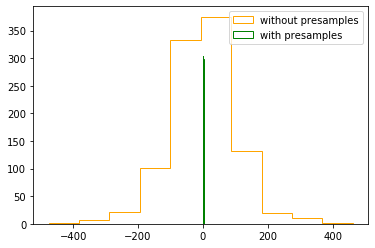

In [13]:
act = [act for act in bw.Database('ei36_cutoff') if act['name']=='polyester-complexed starch biopolymer production'][0]
print("Working on activity known to have non-negligeable land transformation impacts: ", act)
check_presamples_act(act.key, presamples_fp, m)

Randomly working on  'water pump operation, diesel' (megajoule, CH, None)


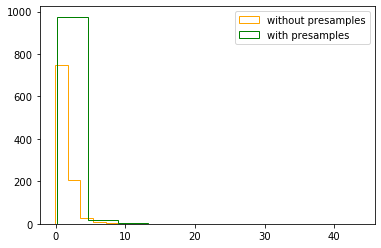

In [14]:
act = bw.Database('ei36_cutoff').random()
print("Randomly working on ", act)
check_presamples_act(act.key, presamples_fp, m)

Randomly working on  'lithium hexafluorophosphate production' (kilogram, CN, None)


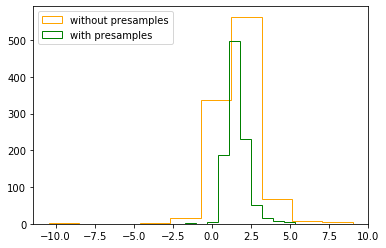

In [15]:
act = bw.Database('ei36_cutoff').random()
print("Randomly working on ", act)
check_presamples_act(act.key, presamples_fp, m)

Randomly working on  'market for laser machining, metal, with CO2-laser, 2700W power' (hour, GLO, None)


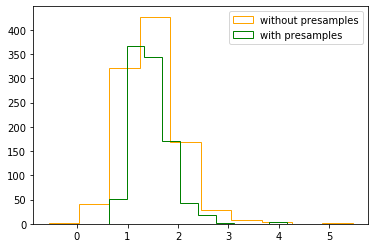

In [16]:
act = bw.Database('ei36_cutoff').random()
print("Randomly working on ", act)
check_presamples_act(act.key, presamples_fp, m)

Randomly working on  'heat and power co-generation, oil' (kilowatt hour, LV, None)


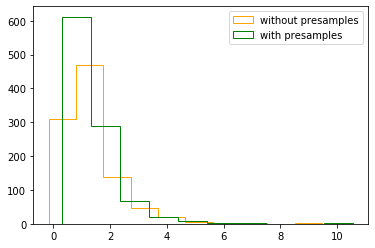

In [17]:
act = bw.Database('ei36_cutoff').random()
print("Randomly working on ", act)
check_presamples_act(act.key, presamples_fp, m)